In [197]:
import json as json
import pathlib as pl
from datetime import datetime
from gc import collect
from os import path, system

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from numpy import array, meshgrid, ones
from numpy.linalg import norm
from scipy.spatial.transform import Rotation
from tqdm import tqdm

from calc_catenary_from_ext_points import get_coor_marker_points_ideal_catenary
from utils import check, gif_from_pngs, print_dict

gain = 1.5
rcParams[ 'figure.figsize' ] = [ gain * 6.4, gain * 4.8 / 2 ]

In [198]:
for v in pl.Path( "./export" ).glob( '*' ):
	if datetime.fromtimestamp( path.getctime( v ) ).date() >= datetime.fromisocalendar( 2024, 37, 2 ).date():
		print( str( v ).split( '//' )[ -1 ], end = '\t' )
		print( datetime.fromtimestamp( path.getctime( v ) ), end = '\t' )
		try:
			record = pd.read_csv( f'{v}/logs.txt', sep = '\t' ).shape[ 0 ]
			with open( f'{v}/config.json' ) as f:
				conf = json.load( f )
		except:
			print( 'unable to read' )
			continue
		planned = array( conf[ 'target_trajectory' ] ).shape[ 0 ] // 2
		print( f'{record=}\t{planned=}\t{record == planned}' )

export\bluerov_1726514489	2024-09-16 21:21:29.375715	record=399	planned=12	False
export\three_robots_chain_1725264976	2024-09-12 22:05:01.853236	record=299	planned=300	False
export\three_robots_chain_1725268112	2024-09-12 22:05:01.928170	record=299	planned=300	False
export\three_robots_chain_1725274451	2024-09-12 22:05:02.010784	record=299	planned=300	False
export\three_robots_chain_1725278516	2024-09-12 22:05:02.088836	record=299	planned=300	False
export\three_robots_chain_1725525073	2024-09-12 22:05:02.166874	record=599	planned=600	False
export\three_robots_chain_1725534896	2024-09-12 22:05:02.353150	record=599	planned=600	False
export\three_robots_chain_1726033948	2024-09-11 07:52:28.967991	record=2000	planned=2000	True
export\three_robots_chain_1726033954	2024-09-12 22:05:02.508750	record=2000	planned=2000	True
export\three_robots_chain_1726033959	2024-09-12 22:05:02.522252	record=2000	planned=2000	True
export\three_robots_chain_1726151643	2024-09-12 16:34:03.025139	record=2000	pla

In [199]:
folder = pl.Path( './export/three_robot_chain_1726514783' )
# folder = pl.Path( './export/three_robots_chain_with_fixed_end_1726429003' )
# folder = pl.Path( './export/three_robots_chain_with_fixed_end_1726242029' )
# folder = pl.Path( './export/three_robots_chain_1726157070' )
id = str( folder ).split( '_' )[ -1 ]
data = pd.read_csv( f'{folder}/logs.txt', sep = '\t' )
with open( f'{folder}/config.json' ) as f:
	conf = json.load( f )
data[ 'time' ] = [ i * conf[ 'model' ][ 'time_step' ] for i in data.index ]
print_dict( conf )

model:
	model_dynamics:
		state_size: 36
		actuation_size: 18
		br0_state: 0:12:None
		br0_pose: 0:6:None
		br0_position: 0:3:None
		br0_xy: 0:2:None
		br0_z: 2
		br0_orientation: 3:6:None
		br0_speed: 6:12:None
		br0_linear_speed: 6:9:None
		br0_angular_speed: 9:12:None
		br0_actuation_start: 0
		br0_actuation: 0:6:None
		br0_linear_actuation: 0:3:None
		br0_angular_actuation: 3:6:None
		br1_state: 12:24:None
		br1_pose: 12:18:None
		br1_position: 12:15:None
		br1_xy: 12:14:None
		br1_z: 14
		br1_orientation: 15:18:None
		br1_speed: 18:24:None
		br1_linear_speed: 18:21:None
		br1_angular_speed: 21:24:None
		br1_actuation_start: 6
		br1_actuation: 6:12:None
		br1_linear_actuation: 6:9:None
		br1_angular_actuation: 9:12:None
		br2_start: 24
		br2_state: 24:36:None
		br2_pose: 24:30:None
		br2_position: 24:27:None
		br2_xy: 24:26:None
		br2_z: 26
		br2_orientation: 27:30:None
		br2_speed: 30:36:None
		br2_linear_speed: 30:33:None
		br2_angular_speed: 33:36:None
		br2_actuation_start: 12


In [200]:
conf[ 'constraints' ][ 0 ][ 'ub' ][ :len( conf[ 'constraints' ][ 0 ][ 'ub' ] ) // conf[ 'horizon' ] ]

[3.00001, 3.00001, 2.8, 2.8, 2.8, 2.8, 3.0, 3.0, 3.0]

In [201]:
conf[ 'constraints' ][ 0 ][ ('lb') ][ :len( conf[ 'constraints' ][ 0 ][ 'ub' ] ) // conf[ 'horizon' ] ]

[-inf, -inf, 0.4, 0.4, -inf, -inf, -inf, -inf, -inf]

In [202]:
data.tail( 10 )

,index,sim_time,step_time,success,C01,C12,D01,D12,H01,H12,...,state_br2,speed_br0,speed_br1,speed_br2,actuation_br0,actuation_br1,actuation_br2,objective,Unnamed: 20,time
1990,1990,3744.565009,1.591096,True,2.326207,1.460610,0.846231,0.960106,1.139118,0.791012,...,"[1.9746062570369363, 0.4047749345496924, -0.1960390949489957, 0.09053382732812569, 0.2569194030561265, -85.69110083011569]","[0.24264092203818782, 0.0019409436842888087, -0.16819690355860556, -0.005113730345437261, 0.00017377913141740971, -0.00024305289749070434]","[0.1805492320861051, 0.16856577754275062, 0.4488387099350128, 0.013623530202158406, -0.038361709764496585, -0.07981385414983658]","[-0.39816069011319444, -0.42976139586654805, 0.006295766908437559, 6.128033421930775, -6.32580833190114, -39.97548983054786]","[-7.461284032051883, -0.3194580506655473, 10.423034672676343, 0.005959706983398756, -0.0038531405751483345, 0.0024584760654387636]","[74.9994740730278, -71.45713425825721, 64.34386281535936, 0.006140912507576675, 0.003461129061541551, 0.061531402914551184]","[-7.461284032051883, -0.3194580506655473, 10.423034672676343, 0.005959706983398756, -0.0038531405751483345, 0.0024584760654387636]",4.381580,NaN,19.90
1991,1991,3747.169312,2.186618,True,2.327677,1.458570,0.846859,0.959431,1.142485,0.788274,...,"[1.9803108876600048, 0.40351388559350854, -0.19584262247802975, 0.05275891350770583, 0.22166854565292415, -86.1072133658137]","[0.23452821253910275, 0.0015334933007510676, -0.16618909803680623, -0.005084307957435597, 0.000206924604479127, -0.0003028805599176296]","[0.2463732390053078, 0.09399188137207043, 0.48606150699710904, 0.014652387109910956, -0.03858644913899465, -0.07609740099646978]","[-0.35622858016777165, -0.4672681647624636, -0.08842948545428364, 6.14791680092625, -6.390238274714758, -40.15471760479012]","[-10.280251381564366, -0.47423915745026024, 10.398554993489576, 0.0025339131935466774, -0.0030944952724849643, -0.000938136454696203]","[74.82885055395367, -86.60150311175882, 47.60837484984552, 0.007245944889698508, 0.0019501271288127767, 0.06492023923239303]","[-10.280251381564366, -0.47423915745026024, 10.398554993489576, 0.0025339131935466774, -0.0030944952724849643, -0.000938136454696203]",4.597749,NaN,19.91
1992,1992,3751.072675,3.371678,True,2.329394,1.459405,0.847476,0.957742,1.146019,0.785654,...,"[1.985276584507225, 0.4003985172411392, -0.19671604470133577, 0.032902065723063624, 0.17408592831731248, -86.5201071720123]","[0.23213220827804273, 0.0014690552722039004, -0.1641941246655207, -0.005018179626734575, 0.00022847014527006807, -0.0003434354656912071]","[0.3056228656448775, 0.013634401014123337, 0.506021809689472, 0.01565250174764477, -0.03862196124341029, -0.07215021807307063]","[-0.3001754818696105, -0.48847642613994985, -0.18318697411303864, 6.172079746454335, -6.448792572517415, -40.334742242736276]","[-3.684873394552998, -0.0786732545060882, 10.37343107190063, 0.002995983300021437, -0.003277083835565818, -0.0006262584664914366]","[67.01908591713168, -92.76975190571325, 27.608374849845518, 0.0070647982416616115, 0.004055323073227079, 0.06834369417872763]","[-3.684873394552998, -0.0786732545060882, 10.37343107190063, 0.002995983300021437, -0.003277083835565818, -0.0006262584664914366]",4.597639,NaN,19.92
1993,1993,3755.237871,3.603461,True,2.331050,1.463118,0.848115,0.955069,1.149594,0.783200,...,"[1.9888698944648056, 0.3960206997719449, -0.19873216105942096, 0.034145938460576876, 0.12220307878705432, -86.93075180587374]","[0.22991679488633834, 0.00137963955860552, -0.16225608656614107, -0.004910943151288348, 0.00023266390202332518, -0.00036730918952699573]","[0.35822624254102103, -0.07247985017298587, 0.5086416872277463, 0.016608804461882704, -0.038476147568630194, -0.06796120356697084]","[-0.2324488693111259, -0.4936102163106535, -0.2736104661567557, 6.197698706487235, -6.500081233935682, -40.51556187848896]","[-3.467917987369649, -0.1072811846136609, 10.297769153219798, 0.0035273709249633144, -0.003550194200715947, -0.00035710

In [203]:
n_robots = len( conf[ 'model' ][ 'state' ] ) // 12

state_br0 = data[ 'state_br0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_br1 = data[ 'state_br1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_br2 = data[ 'state_br2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)

# state_br0[ 'z' ] += 1.
# state_br1[ 'z' ] += 1.
# state_br2[ 'z' ] += 1.

speed_br0 = data[ 'speed_br0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_br0[ 'l_norm' ] = norm( speed_br0[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_br0[ 'a_norm' ] = norm( speed_br0[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_br1 = data[ 'speed_br1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_br1[ 'l_norm' ] = norm( speed_br1[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_br1[ 'a_norm' ] = norm( speed_br1[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_br2 = data[ 'speed_br2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_br2[ 'l_norm' ] = norm( speed_br2[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_br2[ 'a_norm' ] = norm( speed_br2[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

actuation_br0 = data[ 'actuation_br0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_br1 = data[ 'actuation_br1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_br2 = data[ 'actuation_br2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)

# state_br3 = data[ 'state_br3' ].apply(
# 		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
# 		)
# state_br3[ 'z' ] += 1.
# speed_br3 = data[ 'speed_br3' ].apply(
# 		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
# 		)
# speed_br3[ 'l_norm' ] = norm( speed_br3[ [ 'x', 'y', 'z' ] ], axis = 1 )
# speed_br3[ 'a_norm' ] = norm( speed_br3[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

n_frames = len( conf[ 'target_trajectory' ] )
traj = array( conf[ 'target_trajectory' ] )[ :n_frames // 2, :, : ]
# traj[ :, :, 2 ] += 1.

# Errors

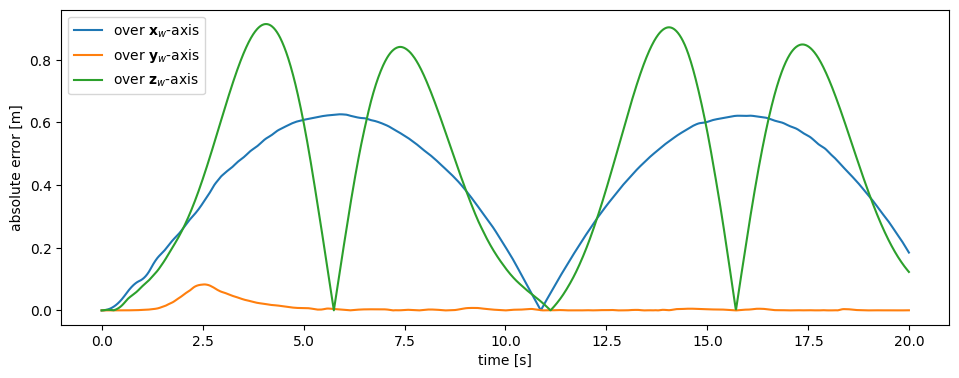

In [204]:
plt.plot( data[ 'time' ], abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_br0[ [ 'x', 'y', 'z' ] ] ) )
plt.legend(
		[
				r'over $\mathbf{x}_w$-axis',
				r'over $\mathbf{y}_w$-axis',
				r'over $\mathbf{z}_w$-axis'
				]
		)
plt.xlabel( 'time [s]' )
plt.ylabel( 'absolute error [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_error.png', dpi = 300 )

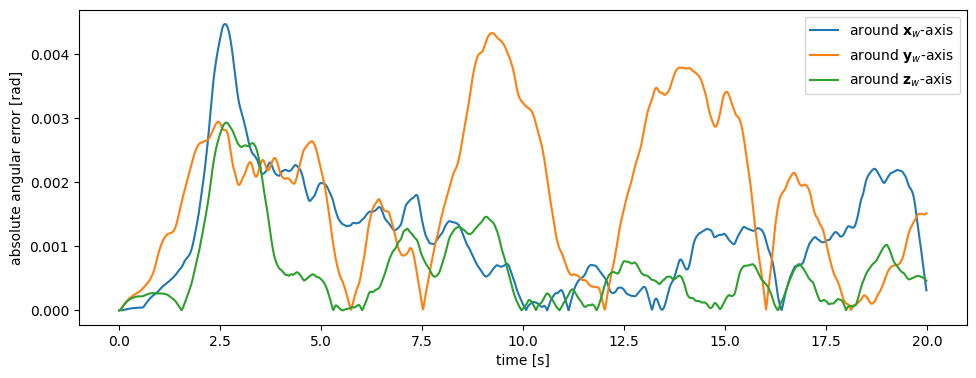

In [205]:
plt.plot( data[ 'time' ], abs( traj[ :data.shape[ 0 ], 0, 3:6 ] - state_br0[ [ 'phi', 'theta', 'psi' ] ] ) )
plt.legend(
		[
				r'around $\mathbf{x}_w$-axis',
				r'around $\mathbf{y}_w$-axis',
				r'around $\mathbf{z}_w$-axis'
				]
		)
plt.xlabel( 'time [s]' )
plt.ylabel( 'absolute angular error [rad]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_angular_error.png', dpi = 300 )

In [206]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_br0[ [ 'x', 'y', 'z' ] ] )).describe()

,x,y,z
count,2000.000000,2.000000e+03,2000.000000
mean,0.414175,8.348648e-03,0.461339
std,0.188510,1.727049e-02,0.296492
min,0.000002,4.832024e-11,0.000002
25%,0.271193,4.439183e-04,0.179423
50%,0.466345,1.952286e-03,0.462995
75%,0.587181,5.129794e-03,0.752798
max,0.625916,8.293080e-02,0.913998


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

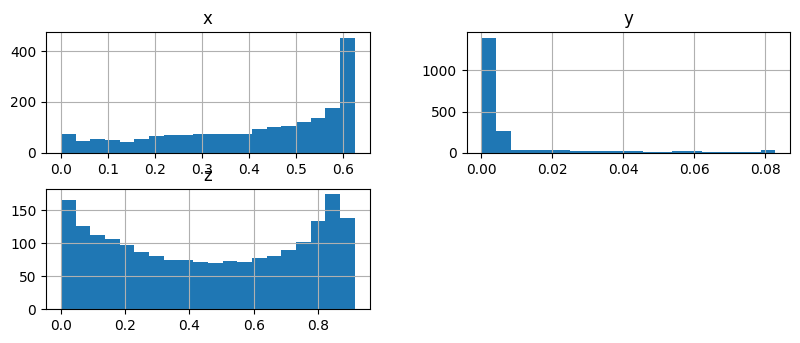

In [207]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_br0[ [ 'x', 'y', 'z' ] ] )).hist( bins = 20 )

<Axes: >

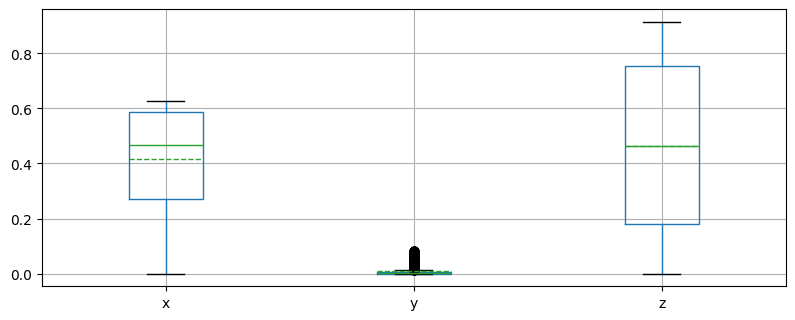

In [208]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_br0[ [ 'x', 'y', 'z' ] ] )).boxplot( meanline = True, showmeans = True )

In [209]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_br0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).describe()

,0
count,2000.000000
mean,0.635559
std,0.322864
min,0.000002
25%,0.357541
50%,0.690055
75%,0.930430
max,1.067573


In [210]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, 3:6 ] - state_br0[ [ 'phi', 'theta', 'psi' ] ], axis = 1 ) ).describe()

,0
count,2000.000000
mean,0.002473
std,0.001231
min,0.000001
25%,0.001492
50%,0.002314
75%,0.003309
max,0.006039


array([[<Axes: title={'center': '0'}>]], dtype=object)

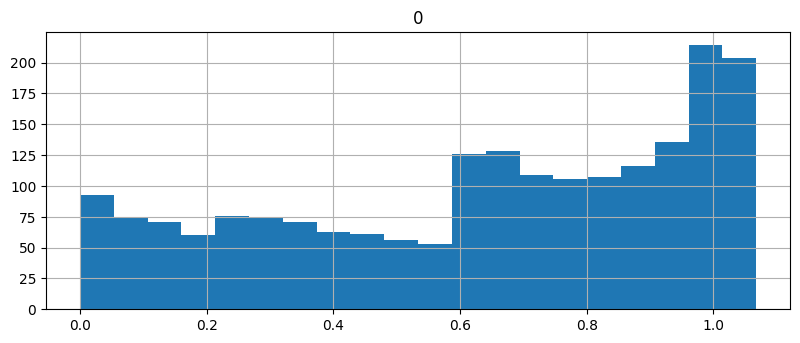

In [211]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_br0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).hist( bins = 20 )

<Axes: >

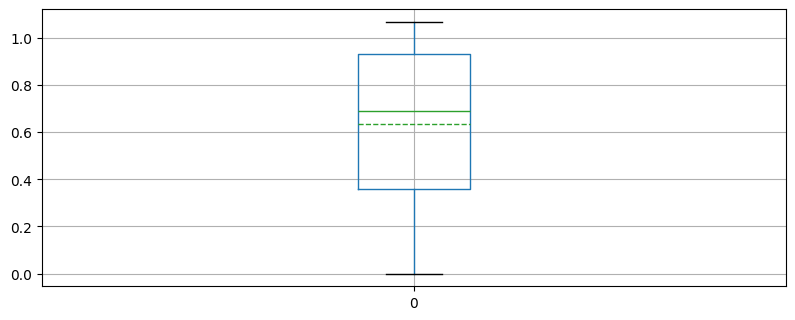

In [212]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_br0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).boxplot(
		meanline = True,
		showmeans = True
		)

# Constraints

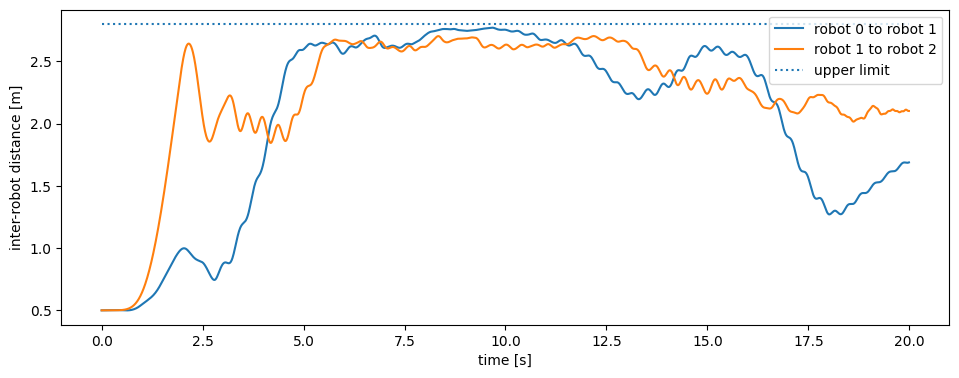

In [213]:
plt.plot( data[ 'time' ], norm( state_br1[ [ 'x', 'y', 'z' ] ] - state_br0[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_br2[ [ 'x', 'y', 'z' ] ] - state_br1[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
# plt.plot( data[ 'time' ], norm( state_br3[ [ 'x', 'y', 'z' ] ] - state_br2[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 2 * (n_robots - 1) ], 0, data[ 'time' ].max(), linestyles = ':' )
plt.legend(
		[
				'robot 0 to robot 1',
				'robot 1 to robot 2',
				# 'robot 2 to fixed point',
				'upper limit'
				]
		)
plt.xlabel( 'time [s]' )
plt.ylabel( 'inter-robot distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_inter_robot_distance.png', dpi = 300 )

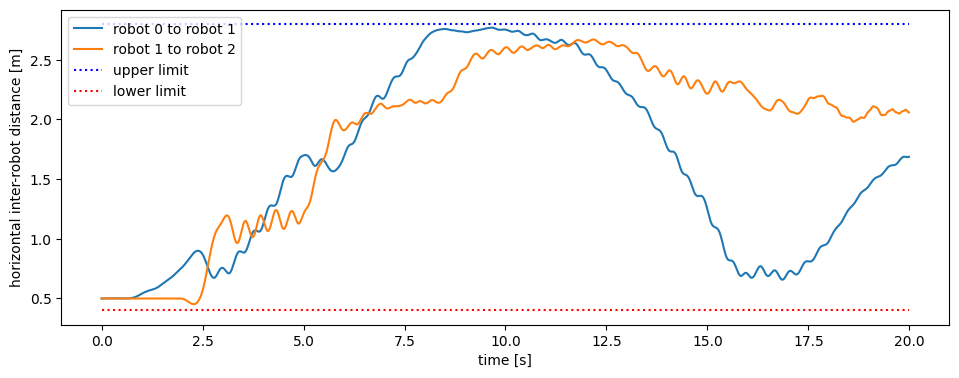

In [214]:
plt.plot( data[ 'time' ], norm( state_br1[ [ 'x', 'y' ] ] - state_br0[ [ 'x', 'y' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_br2[ [ 'x', 'y' ] ] - state_br1[ [ 'x', 'y' ] ], axis = 1 ) )
# plt.plot( data[ 'time' ], norm( state_br3[ [ 'x', 'y' ] ] - state_br2[ [ 'x', 'y' ] ], axis = 1 ) )
plt.hlines(
		conf[ 'constraints' ][ 0 ][ 'ub' ][ (n_robots - 1) ],
		0,
		data[ 'time' ].max(),
		linestyles = ':',
		color = 'b'
		)
plt.hlines(
		conf[ 'constraints' ][ 0 ][ 'lb' ][ (n_robots - 1) ],
		0,
		data[ 'time' ].max(),
		linestyles = ':',
		color = 'r'
		)
plt.legend(
		[
				'robot 0 to robot 1',
				'robot 1 to robot 2',
				# 'robot 2 to fixed point',
				'upper limit',
				'lower limit'
				]
		)
plt.xlabel( 'time [s]' )
plt.ylabel( 'horizontal inter-robot distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_horizontal_inter_robot_distance.png', dpi = 300 )

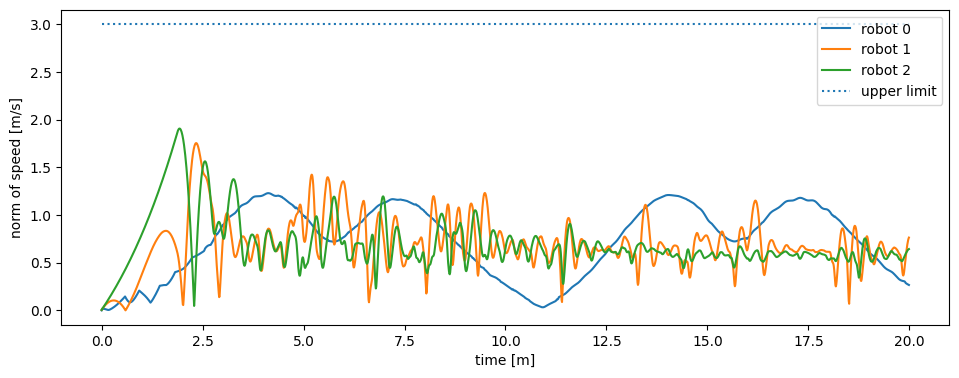

In [215]:
plt.plot( data[ 'time' ], speed_br0[ 'l_norm' ] )
plt.plot( data[ 'time' ], speed_br1[ 'l_norm' ] )
plt.plot( data[ 'time' ], speed_br2[ 'l_norm' ] )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 3 * (n_robots - 1) ], 0, data[ 'time' ].max(), linestyles = ':' )
plt.legend(
		[
				'robot 0',
				'robot 1',
				'robot 2',
				'upper limit'
				]
		)
plt.xlabel( 'time [m]' )
plt.ylabel( 'norm of speed [m/s]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_robots_speed.png', dpi = 300 )

# States

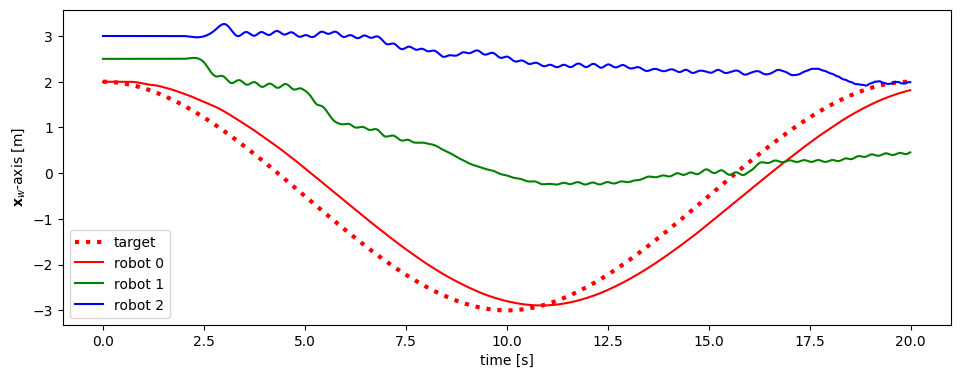

In [216]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 0 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_br0[ 'x' ], 'r' )
plt.plot( data[ 'time' ], state_br1[ 'x' ], 'g' )
plt.plot( data[ 'time' ], state_br2[ 'x' ], 'b' )
# plt.plot( data[ 'time' ], state_br3[ 'x' ], 'y' )

plt.legend(
		[
				'target',
				'robot 0',
				'robot 1',
				'robot 2',
				# 'fixed point'
				]
		)
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{x}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_pose_x.png', dpi = 300 )

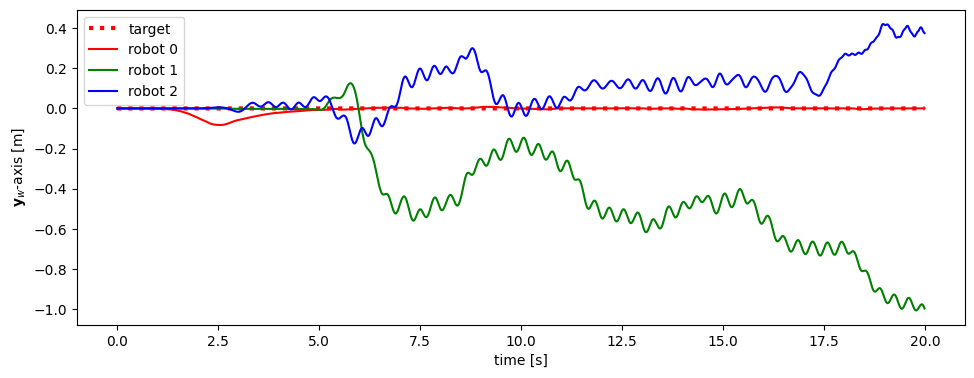

In [217]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 1 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_br0[ 'y' ], 'r' )
plt.plot( data[ 'time' ], state_br1[ 'y' ], 'g' )
plt.plot( data[ 'time' ], state_br2[ 'y' ], 'b' )
# plt.plot( data[ 'time' ], state_br3[ 'y' ], 'y' )

plt.legend(
		[
				'target',
				'robot 0',
				'robot 1',
				'robot 2',
				# 'fixed point'
				]
		)
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{y}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_pose_y.png', dpi = 300 )

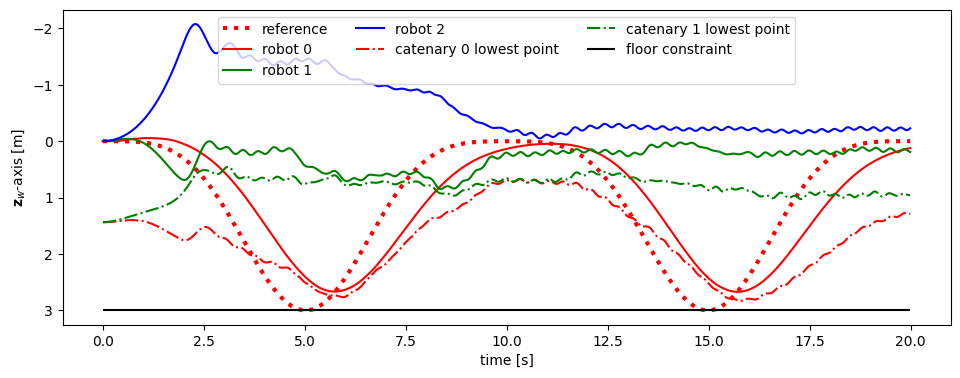

In [218]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 2 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_br0[ 'z' ], 'r' )
plt.plot( data[ 'time' ], state_br1[ 'z' ], 'g' )
plt.plot( data[ 'time' ], state_br2[ 'z' ], 'b' )
# plt.plot( data[ 'time' ], state_br3[ 'z' ], 'y' )
plt.plot( data[ 'time' ], data[ 'H01' ] + state_br0[ 'z' ], '-.', color = 'r' )
plt.plot( data[ 'time' ], data[ 'H12' ] + state_br1[ 'z' ], '-.', color = 'g' )
# plt.plot( data[ 'time' ], data[ 'H23' ] + state_br2[ 'z' ], '-.', color = 'b' )

plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], 0, data[ 'time' ].max(), 'k' )
# plt.ylim( -1.1, 3.1 )
plt.legend(
		[
				'reference',
				'robot 0',
				'robot 1',
				'robot 2',
				# 'fixed point',
				'catenary 0 lowest point',
				'catenary 1 lowest point',
				# 'catenary 2 lowest point',
				'floor constraint'
				],
		ncol = 3,
		loc = 'upper center'
		)
plt.gca().invert_yaxis()
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{z}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_pose_z.png', dpi = 300 )

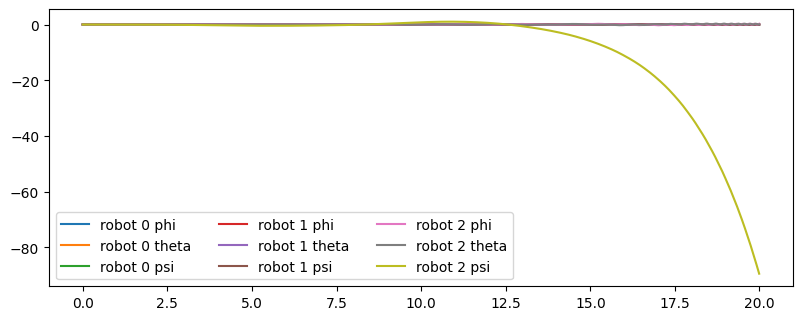

In [219]:
plt.plot( data[ 'time' ], state_br0[ [ 'phi', 'theta', 'psi' ] ] )
plt.plot( data[ 'time' ], state_br1[ [ 'phi', 'theta', 'psi' ] ] )
plt.plot( data[ 'time' ], state_br2[ [ 'phi', 'theta', 'psi' ] ] )
plt.legend(
		[
				'robot 0 phi',
				'robot 0 theta',
				'robot 0 psi',
				'robot 1 phi',
				'robot 1 theta',
				'robot 1 psi',
				'robot 2 phi',
				'robot 2 theta',
				'robot 2 psi'
				], ncol = 3
		)
plt.savefig( f'{folder}/{id}_orientations.png', dpi = 300 )

# Speeds

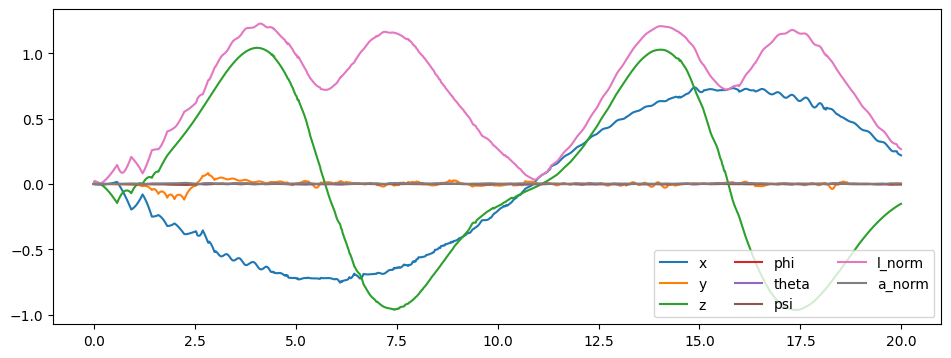

In [220]:
plt.plot( data[ 'time' ], speed_br0 )
plt.legend( speed_br0.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_speed_br0.png', dpi = 300 )

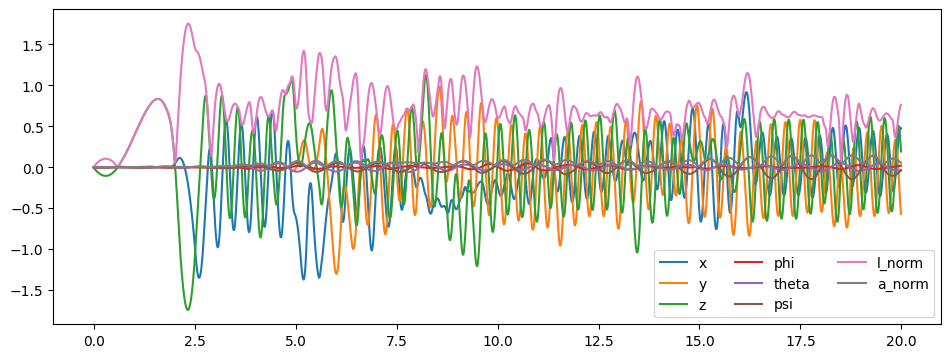

In [221]:
plt.plot( data[ 'time' ], speed_br1 )
plt.legend( speed_br1.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_speed_br1.png', dpi = 300 )

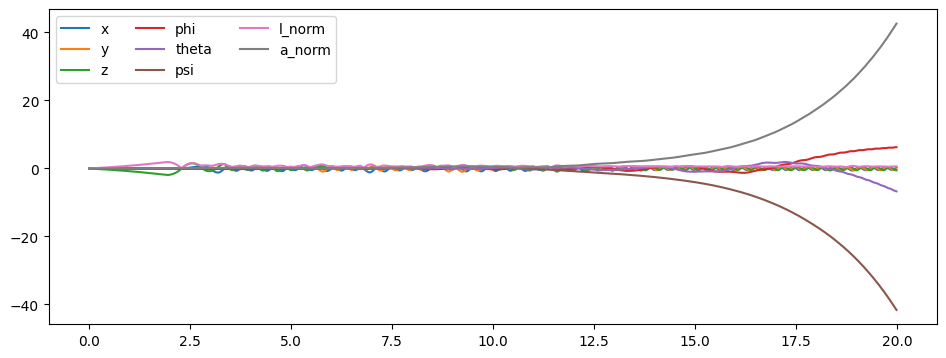

In [222]:
plt.plot( data[ 'time' ], speed_br2 )
plt.legend( speed_br2.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_speed_br2.png', dpi = 300 )

# Actuations

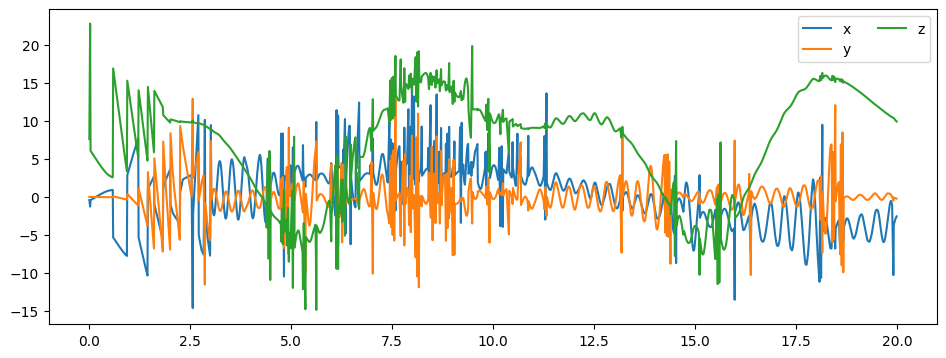

In [223]:
plt.plot( data[ 'time' ], actuation_br0[ actuation_br0.columns[ :3 ] ] )
plt.legend( actuation_br0.columns[ :3 ], ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_br0.png', dpi = 300 )

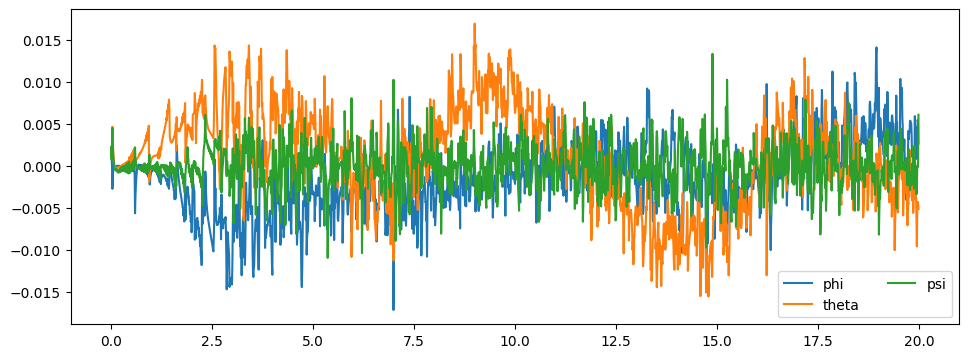

In [224]:
plt.plot( data[ 'time' ], actuation_br0[ actuation_br0.columns[ 3: ] ] )
plt.legend( actuation_br0.columns[ 3: ], ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_br0.png', dpi = 300 )

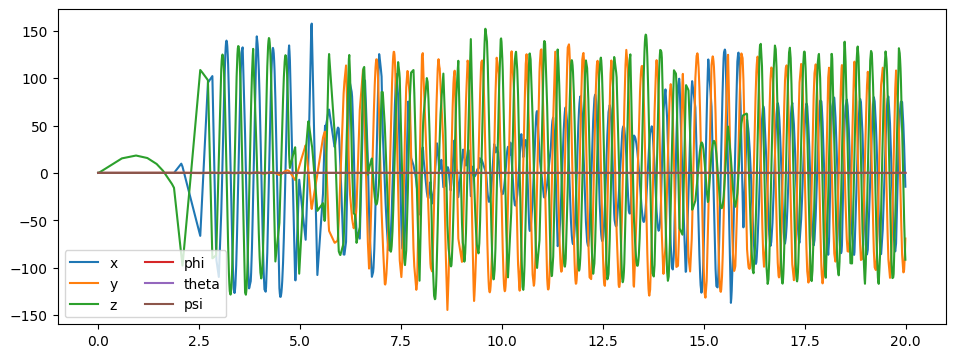

In [225]:
plt.plot( data[ 'time' ], actuation_br1 )
plt.legend( actuation_br1.columns, ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_br1.png', dpi = 300 )

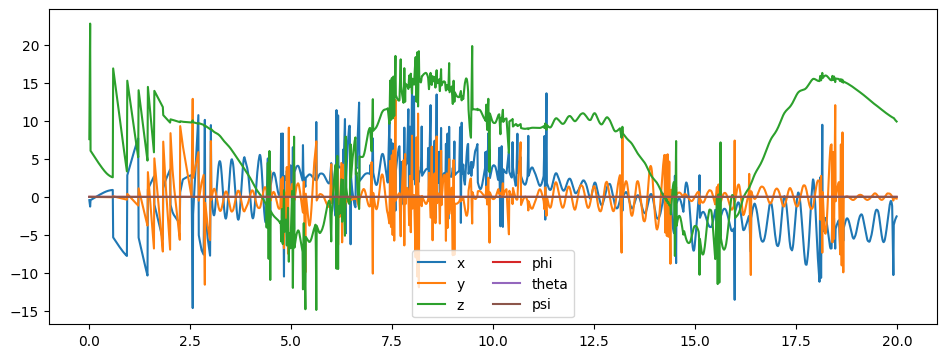

In [226]:
plt.plot( data[ 'time' ], actuation_br2 )
plt.legend( actuation_br2.columns, ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_br2.png', dpi = 300 )

# Time

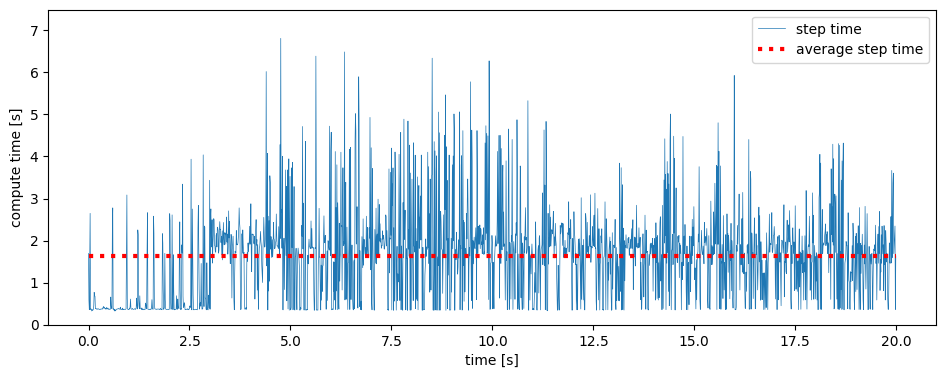

In [227]:
plt.plot( data[ 'time' ], data[ 'step_time' ], linewidth = .5 )
plt.hlines( data.step_time.mean(), 0, data[ 'time' ].max(), linestyles = ':', color = 'r', linewidth = 3 )
plt.ylabel( 'compute time [s]' )
plt.xlabel( 'time [s]' )
plt.gca().set_ylim( 0, data.step_time.max() * 1.1 )
plt.legend( [ 'step time', 'average step time' ] )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_compute_time.png', dpi = 300 )

In [228]:
data[ 'step_time' ].describe()

count    2000.000000
mean        1.623512
std         1.070216
min         0.326213
25%         0.585762
50%         1.691112
75%         2.094705
max         6.807983
Name: step_time, dtype: float64

<Axes: >

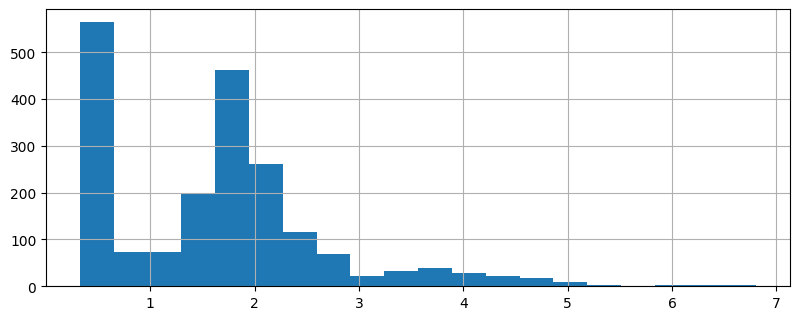

In [229]:
data[ 'step_time' ].hist( bins = 20 )

<Axes: >

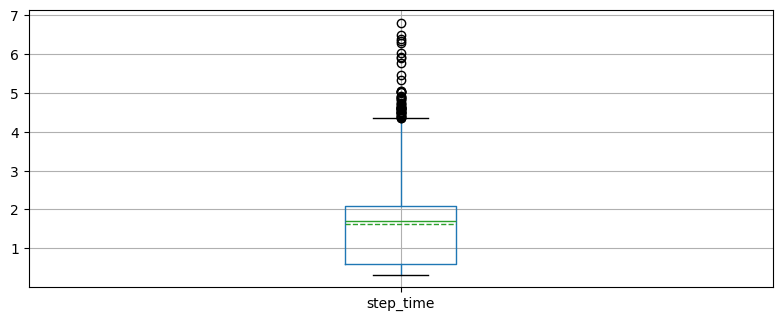

In [230]:
data[ 'step_time' ].to_frame().boxplot( meanline = True, showmeans = True )

In [231]:
def plot( i: int ):
	volume = array( [ [ -3.5, 3.5 ], [ -3.5, 3.5 ], [ -2, 5 ] ] )
	fig = plt.figure( figsize = (10, 10) )
	view = plt.subplot( projection = '3d' )
	view.set_xlabel( "x" )
	view.set_ylabel( "y" )
	view.set_zlabel( "z" )
	view.set_xlim( *volume[ 0 ] )
	view.set_ylim( *volume[ 1 ] )
	view.set_zlim( *volume[ 2 ] )
	view.invert_yaxis()
	view.invert_zaxis()

	inset_view_xz = view.inset_axes( [ .0, .0, .2, .2 ] )
	inset_view_xz.set_xlabel( "x" )
	inset_view_xz.set_ylabel( "z" )
	inset_view_xz.set_xlim( *volume[ 0 ] )
	inset_view_xz.set_ylim( *volume[ 2 ] )
	inset_view_xz.invert_yaxis()

	inset_view_yz = view.inset_axes( [ .8, .0, .2, .2 ] )
	inset_view_yz.set_xlabel( "y" )
	inset_view_yz.set_ylabel( "z" )
	inset_view_yz.set_xlim( *volume[ 1 ] )
	inset_view_yz.set_ylim( *volume[ 2 ] )
	inset_view_yz.invert_xaxis()
	inset_view_yz.invert_yaxis()

	inset_view_xy = view.inset_axes( [ .0, .8, .2, .2 ] )
	inset_view_xy.set_xlabel( "x" )
	inset_view_xy.set_ylabel( "y" )
	inset_view_xy.set_xlim( *volume[ 0 ] )
	inset_view_xy.set_ylim( *volume[ 1 ] )
	inset_view_xy.invert_yaxis()

	surf_x = [ volume[ 0 ][ 0 ], volume[ 0 ][ 1 ] ]
	surf_y = volume[ 1 ]
	surf_x, surf_y = meshgrid( surf_x, surf_y )
	surf_z = ones( surf_x.shape ) * (conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ])
	view.plot_surface( surf_x, surf_y, surf_z, alpha = 0.1 )
	inset_view_xz.plot(
			[ volume[ 0 ][ 0 ], volume[ 0 ][ 1 ] ],
			[ conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ] ]
			)
	inset_view_yz.plot(
			[ volume[ 1 ][ 0 ], volume[ 1 ][ 1 ] ],
			[ conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ] ]
			)

	target_pose = traj[ i, 0 ]

	view.plot( traj[ :, 0, 0 ], traj[ :, 0, 1 ], traj[ :, 0, 2 ], ':' )
	inset_view_xz.plot( traj[ :, 0, 0 ], traj[ :, 0, 2 ], ':' )
	inset_view_yz.plot( traj[ :, 0, 1 ], traj[ :, 0, 2 ], ':' )
	inset_view_xy.plot( traj[ :, 0, 0 ], traj[ :, 0, 1 ], ':' )

	r0 = Rotation.from_euler( 'xyz', state_br0.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r1 = Rotation.from_euler( 'xyz', state_br1.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r2 = Rotation.from_euler( 'xyz', state_br2.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	# r3 = Rotation.from_euler( 'xyz', state_br3.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r0t = Rotation.from_euler( 'xyz', target_pose[ 3:6 ] ).as_matrix()

	quiver_scale = .25
	view.quiver(
			*state_br0.iloc[ i ].to_numpy()[ :3 ], *(r0 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'red'
			)
	view.quiver(
			*state_br1.iloc[ i ].to_numpy()[ :3 ], *(r1 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'green'
			)
	view.quiver(
			*state_br2.iloc[ i ].to_numpy()[ :3 ],
			*(r2 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'blue'
			)
	# view.quiver(
	# 		*state_br3.iloc[ i ].to_numpy()[ :3 ],
	# 		*(r3 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
	# 		color = 'yellow'
	# 		)
	view.quiver(
			*target_pose[ :3 ], *(r0t @ (quiver_scale * array( [ 1., 0., 0. ] ))), color = 'black'
			)

	inset_view_xz.scatter( state_br0.iloc[ i ].to_numpy()[ 0 ], state_br0.iloc[ i ].to_numpy()[ 2 ], color = 'red' )
	inset_view_xz.scatter( state_br1.iloc[ i ].to_numpy()[ 0 ], state_br1.iloc[ i ].to_numpy()[ 2 ], color = 'green' )
	inset_view_xz.scatter( state_br2.iloc[ i ].to_numpy()[ 0 ], state_br2.iloc[ i ].to_numpy()[ 2 ], color = 'blue' )
	# inset_view_xz.scatter( state_br3.iloc[ i ].to_numpy()[ 0 ], state_br3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow' )

	inset_view_yz.scatter( state_br0.iloc[ i ].to_numpy()[ 1 ], state_br0.iloc[ i ].to_numpy()[ 2 ], color = 'red' )
	inset_view_yz.scatter( state_br1.iloc[ i ].to_numpy()[ 1 ], state_br1.iloc[ i ].to_numpy()[ 2 ], color = 'green' )
	inset_view_yz.scatter( state_br2.iloc[ i ].to_numpy()[ 1 ], state_br2.iloc[ i ].to_numpy()[ 2 ], color = 'blue' )
	# inset_view_yz.scatter( state_br3.iloc[ i ].to_numpy()[ 1 ], state_br3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow' )

	inset_view_xy.scatter( state_br0.iloc[ i ].to_numpy()[ 0 ], state_br0.iloc[ i ].to_numpy()[ 1 ], color = 'red' )
	inset_view_xy.scatter( state_br1.iloc[ i ].to_numpy()[ 0 ], state_br1.iloc[ i ].to_numpy()[ 1 ], color = 'green' )
	inset_view_xy.scatter( state_br2.iloc[ i ].to_numpy()[ 0 ], state_br2.iloc[ i ].to_numpy()[ 1 ], color = 'blue' )
	# inset_view_xy.scatter( state_br3.iloc[ i ].to_numpy()[ 0 ], state_br3.iloc[ i ].to_numpy()[ 1 ], color = 'yellow' )

	view.plot(
			state_br0[ 'x' ].to_numpy()[ :i ],
			state_br0[ 'y' ].to_numpy()[ :i ],
			state_br0[ 'z' ].to_numpy()[ :i ],
			color = 'red'
			)
	view.plot(
			state_br1[ 'x' ].to_numpy()[ :i ],
			state_br1[ 'y' ].to_numpy()[ :i ],
			state_br1[ 'z' ].to_numpy()[ :i ],
			color = 'green'
			)
	view.plot(
			state_br2[ 'x' ].to_numpy()[ :i ],
			state_br2[ 'y' ].to_numpy()[ :i ],
			state_br2[ 'z' ].to_numpy()[ :i ],
			color = 'blue'
			)
	# view.plot(
	# 		state_br3[ 'x' ].to_numpy()[ :i ],
	# 		state_br3[ 'y' ].to_numpy()[ :i ],
	# 		state_br3[ 'z' ].to_numpy()[ :i ],
	# 		color = 'yellow'
	# 		)

	inset_view_xz.plot(
			state_br0.iloc[ i ].to_numpy()[ 0 ], state_br0.iloc[ i ].to_numpy()[ 2 ], color = 'red'
			)
	inset_view_xz.plot(
			state_br1.iloc[ i ].to_numpy()[ 0 ], state_br1.iloc[ i ].to_numpy()[ 2 ], color = 'green'
			)
	inset_view_xz.plot(
			state_br2.iloc[ i ].to_numpy()[ 0 ], state_br2.iloc[ i ].to_numpy()[ 2 ], color = 'blue'
			)
	# inset_view_xz.plot(
	# 		state_br3.iloc[ i ].to_numpy()[ 0 ], state_br3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow'
	# 		)

	inset_view_yz.plot(
			state_br0.iloc[ i ].to_numpy()[ 1 ], state_br0.iloc[ i ].to_numpy()[ 2 ], color = 'red'
			)
	inset_view_yz.plot(
			state_br1.iloc[ i ].to_numpy()[ 1 ], state_br1.iloc[ i ].to_numpy()[ 2 ], color = 'green'
			)
	inset_view_yz.plot(
			state_br2.iloc[ i ].to_numpy()[ 1 ], state_br2.iloc[ i ].to_numpy()[ 2 ], color = 'blue'
			)
	# inset_view_yz.plot(
	# 		state_br3.iloc[ i ].to_numpy()[ 1 ], state_br3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow'
	# 		)

	inset_view_xy.plot(
			state_br0.iloc[ i ].to_numpy()[ 0 ], state_br0.iloc[ i ].to_numpy()[ 1 ], color = 'red'
			)
	inset_view_xy.plot(
			state_br1.iloc[ i ].to_numpy()[ 0 ], state_br1.iloc[ i ].to_numpy()[ 1 ], color = 'green'
			)
	inset_view_xy.plot(
			state_br2.iloc[ i ].to_numpy()[ 0 ], state_br2.iloc[ i ].to_numpy()[ 1 ], color = 'blue'
			)
	# inset_view_xy.plot(
	# 		state_br3.iloc[ i ].to_numpy()[ 0 ], state_br3.iloc[ i ].to_numpy()[ 1 ], color = 'yellow'
	# 		)

	try:
		cat01, _, _, H01 = get_coor_marker_points_ideal_catenary(
				state_br0.iloc[ i ].to_numpy()[ 0 ],
				-state_br0.iloc[ i ].to_numpy()[ 1 ],
				-state_br0.iloc[ i ].to_numpy()[ 2 ],
				state_br1.iloc[ i ].to_numpy()[ 0 ],
				-state_br1.iloc[ i ].to_numpy()[ 1 ],
				-state_br1.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		cat12, _, _, H12 = get_coor_marker_points_ideal_catenary(
				state_br1.iloc[ i ].to_numpy()[ 0 ],
				-state_br1.iloc[ i ].to_numpy()[ 1 ],
				-state_br1.iloc[ i ].to_numpy()[ 2 ],
				state_br2.iloc[ i ].to_numpy()[ 0 ],
				-state_br2.iloc[ i ].to_numpy()[ 1 ],
				-state_br2.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		# cat23, _, _, H23 = get_coor_marker_points_ideal_catenary(
		# 		state_br2.iloc[ i ].to_numpy()[ 0 ],
		# 		-state_br2.iloc[ i ].to_numpy()[ 1 ],
		# 		-state_br2.iloc[ i ].to_numpy()[ 2 ],
		# 		state_br3.iloc[ i ].to_numpy()[ 0 ],
		# 		-state_br3.iloc[ i ].to_numpy()[ 1 ],
		# 		-state_br3.iloc[ i ].to_numpy()[ 2 ],
		# 		3.,
		# 		.2
		# 		)
		cat01[ :, 1: ] *= -1
		cat12[ :, 1: ] *= -1
	# cat23[ :, 1: ] *= -1
	except:
		cat01 = array( [ state_br0.iloc[ i ].to_numpy()[ :3 ], state_br1.iloc[ i ].to_numpy()[ :3 ] ] )
		cat12 = array( [ state_br1.iloc[ i ].to_numpy()[ :3 ], state_br2.iloc[ i ].to_numpy()[ :3 ] ] )
		# cat23 = array( [ state_br2.iloc[ i ].to_numpy()[ :3 ], state_br3.iloc[ i ].to_numpy()[ :3 ] ] )
		H01 = None
		H12 = None
	# H23 = None

	view.plot( cat01[ :, 0 ], cat01[ :, 1 ], cat01[ :, 2 ], 'red' )
	view.plot( cat12[ :, 0 ], cat12[ :, 1 ], cat12[ :, 2 ], 'green' )
	# view.plot( cat23[ :, 0 ], cat23[ :, 1 ], cat23[ :, 2 ], 'blue' )

	inset_view_xz.plot( cat01[ :, 0 ], cat01[ :, 2 ], 'red' )
	inset_view_xz.plot( cat12[ :, 0 ], cat12[ :, 2 ], 'green' )
	# inset_view_xz.plot( cat23[ :, 0 ], cat23[ :, 2 ], 'blue' )
	inset_view_yz.plot( cat01[ :, 1 ], cat01[ :, 2 ], 'red' )
	inset_view_yz.plot( cat12[ :, 1 ], cat12[ :, 2 ], 'green' )
	# inset_view_yz.plot( cat23[ :, 1 ], cat23[ :, 2 ], 'blue' )
	inset_view_xy.plot( cat01[ :, 0 ], cat01[ :, 1 ], 'red' )
	inset_view_xy.plot( cat12[ :, 0 ], cat12[ :, 1 ], 'green' )
	# inset_view_xy.plot( cat23[ :, 0 ], cat23[ :, 1 ], 'blue' )

	plt.savefig( f'{folder}/plot/{i}.png', dpi = 100 )
	plt.close( 'all' )
	del fig


check( f'{folder}/plot' )

if input( f"{folder} make video? (y/n) " ) == 'y':
	fig = plt.figure( figsize = (10, 10) )
	for i in tqdm( range( data.shape[ 0 ] ) ):
		plot( i )
	gif_from_pngs( f'{folder}/plot' )
	system( f'ffmpeg -itsscale 0.25 -i {folder}/plot/animation.gif {folder}/plot/video.mp4' )
else:
	print( 'No video created' )

100%|██████████| 2000/2000 [08:31<00:00,  3.91it/s]


MemoryError: 

In [159]:
collect()

12307614

In [161]:
print( folder )

export\three_robot_chain_1726514783


<img src="export/three_robot_chain_1726514783/plot/animation.gif"/>
